In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report
from xgboost import XGBClassifier
from sklearn.feature_selection import SelectFromModel
import optuna

In [ ]:
data_original = pd.read_csv("/kaggle/input/horse-survival-dataset/horse.csv")
data_synthetic = pd.read_csv("/kaggle/input/playground-series-s3e22/train.csv")

In [ ]:
data = pd.concat([data_synthetic,data_original])

In [ ]:
data = data.reset_index().drop(['index', 'id'], axis = 1)

In [ ]:
msno.matrix(data, figsize = (15, 5))

In [ ]:
pd.options.display.max_columns = None

In [ ]:
data.head()

In [ ]:
data.info()

In [ ]:
data.describe()

In [ ]:
num_cols = [col for col in data.columns[data.dtypes != 'O']]
cat_cols = [col for col in data.columns.difference(num_cols) if col != 'outcome']

In [ ]:
data[cat_cols + ['outcome']].describe().T

In [ ]:
data['outcome'].value_counts().plot.bar(figsize = (4,3))

In [ ]:
plt.figure(figsize = (15,18))
for i, col in enumerate(num_cols[1:]):
    plt.subplot(4, 3, i+1)
    sns.histplot(data, x = col, kde = True, color = 'red', alpha = 0.3)
    plt.xlabel(col, fontsize = 15)
    plt.ylabel("Frequency", fontsize = 15)
    plt.xticks(fontsize = 13)
    plt.legend(fontsize = 11)
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize = (15,18))
for i, col in enumerate(num_cols[1:]):
    plt.subplot(4, 3, i+1)
    sns.stripplot(data, x = col, hue = 'outcome')
    plt.xlabel(col, fontsize = 15)
    plt.xticks(fontsize = 13)
    plt.legend(fontsize = 11)
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize = (18,24))
for i, col in enumerate(cat_cols):
    plt.subplot(6, 3, i+1)
    sns.countplot(data, y = col)
    plt.ylabel(col, fontsize = 15)
    plt.xlabel("Count", fontsize = 15)
    plt.xticks(fontsize = 13)
    plt.yticks(fontsize = 13)
plt.tight_layout()
plt.show()

## Data Preprosessing

In [ ]:
X = data.drop('outcome', axis = 1)
y = data['outcome'].copy()

In [ ]:
X.head()

In [ ]:
y.head()

In [ ]:
X.isna().sum()

In [ ]:
y.isna().sum()

### Imputations

In [ ]:
# Handling Missing Values
num_imp = SimpleImputer(missing_values=np.nan, strategy='median')
cat_imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
num_imp.fit(X[num_cols])
cat_imp.fit(X[cat_cols])
X_num_array_imputed = num_imp.transform(X[num_cols])
X_cat_array_imputed = cat_imp.transform(X[cat_cols])
X_num_imputed = pd.DataFrame(X_num_array_imputed, columns = num_cols)
X_cat_imputed = pd.DataFrame(X_cat_array_imputed, columns = cat_cols)
X_imputed = pd.concat([X_num_imputed, X_cat_imputed], axis = 1)

In [ ]:
X = X_imputed.copy()

In [ ]:
X.isna().sum()

### Label encoding

In [ ]:
mask = {'died': 0, 'euthanized': 1, 'lived':2}
y = y.map(mask)

In [ ]:
le_age = LabelEncoder()
X['age'] = le_age.fit_transform(X['age'])

le_cp_data = LabelEncoder()
X['cp_data'] = le_cp_data.fit_transform(X['cp_data'])

le_surgery = LabelEncoder()
X['surgery'] = le_surgery.fit_transform(X['surgery'])

le_surgical_lesion = LabelEncoder()
X['surgical_lesion'] = le_surgical_lesion.fit_transform(X['surgical_lesion'])

In [ ]:
X.head()

### One Hot Encoding

In [ ]:
X = pd.get_dummies(X)

In [ ]:
X

In [ ]:
bool_cols = X.columns[X.dtypes == 'bool']
X[bool_cols] = X[bool_cols].astype('int')

In [ ]:
X.head()

## Training Model

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state=42, stratify=y)

In [ ]:
print(f'X_train Shape: {X_train.shape}')
print(f'X_val Shape: {X_val.shape}')
print(f'y_train Shape: {y_train.shape}')      
print(f'y_val Shape: {y_val.shape}')

In [ ]:
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

In [ ]:
xgb = XGBClassifier(objective = 'multi:softmax', num_class = 3)
xgb.fit(X_train, y_train, verbose = 0, sample_weight = sample_weights)

In [ ]:
y_pred = xgb.predict(X_val)

In [57]:
print('Classification Report')
print('======================================================')
print(classification_report(y_val, y_pred))
print(f'Micro Averaged F1 Score: {f1_score(y_val, y_pred, average="micro"):.5f}')

Classification Report
              precision    recall  f1-score   support

           0       0.69      0.80      0.74        97
           1       0.70      0.59      0.64        59
           2       0.81      0.77      0.79       151

    accuracy                           0.75       307
   macro avg       0.73      0.72      0.73       307
weighted avg       0.75      0.75      0.75       307

Micro Averaged F1 Score: 0.74919


## Feature Selection

In [ ]:
selection = SelectFromModel(xgb, threshold = 0.0084866, prefit = True)
select_X_train = selection.transform(X_train)
select_X_val = selection.transform(X_val)
eval_set = [(select_X_train, y_train), (select_X_val, y_val)]
selection_model = XGBClassifier(objective = 'multi:softmax', num_class = 3)
selection_model.fit(select_X_train, y_train, eval_metric = 'merror', eval_set = eval_set, verbose = False, sample_weight = sample_weights)

In [ ]:
select_X_train.shape[1]

In [ ]:
results = selection_model.evals_result()

In [ ]:
results['validation_0']['merror']
epochs = range(len(results['validation_0']['merror']))
fig = plt.figure(figsize = (8, 5))
plt.plot(epochs, results['validation_0']['merror'])
plt.plot(epochs, results['validation_1']['merror'])
plt.ylabel("M Error")
plt.show()

In [51]:
y_pred = selection_model.predict(select_X_val)

In [52]:
print('Classification Report')
print('=======================')
print(classification_report(y_val, y_pred))
print(f'Micro Averaged F1 Score: {f1_score(y_val, y_pred, average="micro"):.5f}')

Classification Report
              precision    recall  f1-score   support

           0       0.69      0.80      0.74        97
           1       0.70      0.59      0.64        59
           2       0.81      0.77      0.79       151

    accuracy                           0.75       307
   macro avg       0.73      0.72      0.73       307
weighted avg       0.75      0.75      0.75       307

Micro Averaged F1 Score: 0.74919


## Hyperparamter Tuning

In [53]:
best_params = {'n_estimators': 266, 'max_depth': 12, 'learning_rate': 0.05048130591496652, 'subsample': 0.7044860271218132, 'colsample_bytree': 0.695841158492672, 'min_child_weight': 2, 'gamma': 2.148849081154715e-06, 'lambda': 0.0033129112972974896}
print(f'Best hyperparameters: {best_params}')

Best hyperparameters: {'n_estimators': 266, 'max_depth': 12, 'learning_rate': 0.05048130591496652, 'subsample': 0.7044860271218132, 'colsample_bytree': 0.695841158492672, 'min_child_weight': 2, 'gamma': 2.148849081154715e-06, 'lambda': 0.0033129112972974896}


In [54]:
tuned_selection_model = XGBClassifier(**best_params,objective = 'multi:softmax', num_class = 3)
tuned_selection_model.fit(select_X_train, y_train, eval_metric = 'merror', eval_set = eval_set, verbose = False, sample_weight = sample_weights)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.695841158492672, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=2.148849081154715e-06, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              lambda=0.0033129112972974896, learning_rate=0.05048130591496652,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=12, max_leaves=None,
              min_child_weight=2, missing=nan, monotone_constraints=None,
              n_estimators=266, n_jobs=None, num_class=3,
              num_parallel_tree=None, ...)

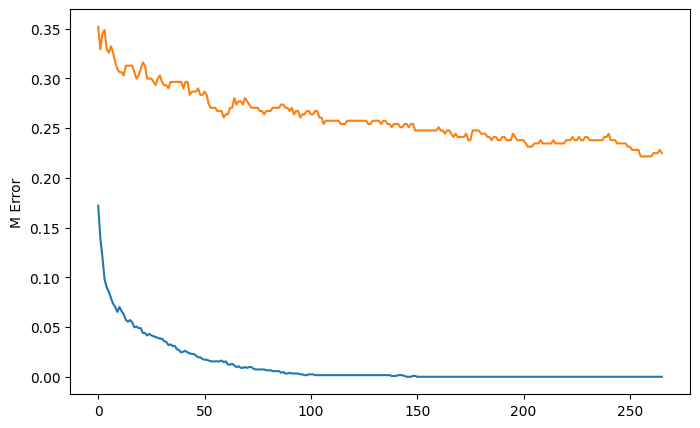

In [55]:
results = tuned_selection_model.evals_result()
results['validation_0']['merror']
epochs = range(len(results['validation_0']['merror']))
fig = plt.figure(figsize = (8, 5))
plt.plot(epochs, results['validation_0']['merror'])
plt.plot(epochs, results['validation_1']['merror'])
plt.ylabel("M Error")
plt.show()

In [56]:
y_pred_tuned = tuned_selection_model.predict(select_X_val)

In [58]:
print('Classification Report')
print('=======================')
print(classification_report(y_val, y_pred))
print(f'Micro Averaged F1 Score: {f1_score(y_val, y_pred_tuned, average="micro"):.5f}')

Classification Report
              precision    recall  f1-score   support

           0       0.69      0.80      0.74        97
           1       0.70      0.59      0.64        59
           2       0.81      0.77      0.79       151

    accuracy                           0.75       307
   macro avg       0.73      0.72      0.73       307
weighted avg       0.75      0.75      0.75       307

Micro Averaged F1 Score: 0.77524


## Testing

In [59]:
test_data = pd.read_csv('/kaggle/input/playground-series-s3e22/test.csv')

In [60]:
test_data_num_array_imputed = num_imp.transform(test_data[num_cols])
test_data_cat_array_imputed = cat_imp.transform(test_data[cat_cols])
test_data_num_imputed = pd.DataFrame(test_data_num_array_imputed, columns = num_cols)
test_data_cat_imputed = pd.DataFrame(test_data_cat_array_imputed, columns = cat_cols)
test_data_imputed = pd.concat([test_data_num_imputed, test_data_cat_imputed], axis = 1)

In [61]:
test_data = test_data_imputed.copy()

In [63]:
test_data.columns

Index(['hospital_number', 'rectal_temp', 'pulse', 'respiratory_rate',
       'nasogastric_reflux_ph', 'packed_cell_volume', 'total_protein',
       'abdomo_protein', 'lesion_1', 'lesion_2', 'lesion_3', 'abdomen',
       'abdominal_distention', 'abdomo_appearance', 'age',
       'capillary_refill_time', 'cp_data', 'mucous_membrane',
       'nasogastric_reflux', 'nasogastric_tube', 'pain', 'peripheral_pulse',
       'peristalsis', 'rectal_exam_feces', 'surgery', 'surgical_lesion',
       'temp_of_extremities'],
      dtype='object')

### Label encoding

In [64]:
test_data['age'] = le_age.fit_transform(test_data['age'])
test_data['cp_data'] = le_cp_data.fit_transform(test_data['cp_data'])
test_data['surgery'] = le_surgery.fit_transform(test_data['surgery'])
test_data['surgical_lesion'] = le_surgical_lesion.fit_transform(test_data['surgical_lesion'])

### One hot encoding

In [66]:
test_data = pd.get_dummies(test_data)
bool_cols = test_data.columns[test_data.dtypes == 'bool']
test_data[bool_cols] = test_data[bool_cols].astype('int')

In [67]:
test_data

,hospital_number,rectal_temp,pulse,respiratory_rate,nasogastric_reflux_ph,packed_cell_volume,total_protein,abdomo_protein,lesion_1,lesion_2,lesion_3,age,cp_data,surgery,surgical_lesion,abdomen_distend_large,abdomen_distend_small,abdomen_firm,abdomen_normal,abdomen_other,abdominal_distention_moderate,abdominal_distention_none,abdominal_distention_severe,abdominal_distention_slight,abdomo_appearance_clear,abdomo_appearance_cloudy,abdomo_appearance_serosanguious,capillary_refill_time_3,capillary_refill_time_less_3_sec,capillary_refill_time_more_3_sec,mucous_membrane_bright_pink,mucous_membrane_bright_red,mucous_membrane_dark_cyanotic,mucous_membrane_normal_pink,mucous_membrane_pale_cyanotic,mucous_membrane_pale_pink,nasogastric_reflux_less_1_liter,nasogastric_reflux_more_1_liter,nasogastric_reflux_none,nasogastric_tube_none,nasogastric_tube_significant,nasogastric_tube_slight,pain_alert,pain_depressed,pain_extreme_pain,pain_mild_pain,pain_moderate,pain_severe_pain,peripheral_pulse_absent,peripheral_pulse_increased,peripheral_pulse_normal,peripheral_pulse_reduced,peristalsis_absent,peristalsis_hypermotile,peristalsis_hypomotile,peristalsis_normal,rectal_exam_feces_absent,rectal_exam_feces_decreased,rectal_exam_feces_increased,rectal_exam_feces_normal,temp_of_extremities_cold,temp_of_extremities_cool,temp_of_extremities_normal,temp_of_extremities_warm
0,534053.0,38.6,40.0,20.0,7.0,42.0,7.5,2.3,0.0,0.0,0.0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0
1,528469.0,38.2,112.0,48.0,3.5,44.0,6.0,2.6,2208.0,0.0,0.0,0,1,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0
2,528178.0,37.7,66.0,12.0,3.0,31.5,6.0,1.6,2205.0,0.0,0.0,0,1,1,1,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0
3,534784.0,37.1,88.0,20.0,2.0,75.0,81.0,1.0,1400.0,0.0,0.0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0
4,529840.0,38.3,50.0,12.0,3.0,37.0,6.8,2.6,2208.0,0.0,0.0,0,1,1,1,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
819,529461.0,40.3,114.0,36.0,7.0,57.0,8.1,4.5,3205.0,0.0,0.0,0,1,0,1,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0
820,535338.0,37.2,100.0,20.0,2.0,50.0,66.0,2.0,2209.0,0.0,0.0,0,0,1,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0
821,529640.0,39.2,132.0,12.0,6.5,53.0,7.6,4.5,2205.0,0.0,0.0,0,0,1,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0
822,5287179.0,38.3,54.0,66.0,7.0,49.0,8.6,5.0,3111.0,0.0,0.0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0


In [68]:
if len(X.columns) != len(test_data.columns):
    test_data[X.columns.difference(test_data.columns)] = 0

In [69]:
test_data = test_data[X_train.columns]
test_data.head()

,hospital_number,rectal_temp,pulse,respiratory_rate,nasogastric_reflux_ph,packed_cell_volume,total_protein,abdomo_protein,lesion_1,lesion_2,lesion_3,age,cp_data,surgery,surgical_lesion,abdomen_distend_large,abdomen_distend_small,abdomen_firm,abdomen_normal,abdomen_other,abdominal_distention_moderate,abdominal_distention_none,abdominal_distention_severe,abdominal_distention_slight,abdomo_appearance_clear,abdomo_appearance_cloudy,abdomo_appearance_serosanguious,capillary_refill_time_3,capillary_refill_time_less_3_sec,capillary_refill_time_more_3_sec,mucous_membrane_bright_pink,mucous_membrane_bright_red,mucous_membrane_dark_cyanotic,mucous_membrane_normal_pink,mucous_membrane_pale_cyanotic,mucous_membrane_pale_pink,nasogastric_reflux_less_1_liter,nasogastric_reflux_more_1_liter,nasogastric_reflux_none,nasogastric_reflux_slight,nasogastric_tube_none,nasogastric_tube_significant,nasogastric_tube_slight,pain_alert,pain_depressed,pain_extreme_pain,pain_mild_pain,pain_severe_pain,pain_slight,peripheral_pulse_absent,peripheral_pulse_increased,peripheral_pulse_normal,peripheral_pulse_reduced,peristalsis_absent,peristalsis_distend_small,peristalsis_hypermotile,peristalsis_hypomotile,peristalsis_normal,rectal_exam_feces_absent,rectal_exam_feces_decreased,rectal_exam_feces_increased,rectal_exam_feces_normal,rectal_exam_feces_serosanguious,temp_of_extremities_cold,temp_of_extremities_cool,temp_of_extremities_normal,temp_of_extremities_warm
0,534053.0,38.6,40.0,20.0,7.0,42.0,7.5,2.3,0.0,0.0,0.0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0
1,528469.0,38.2,112.0,48.0,3.5,44.0,6.0,2.6,2208.0,0.0,0.0,0,1,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0
2,528178.0,37.7,66.0,12.0,3.0,31.5,6.0,1.6,2205.0,0.0,0.0,0,1,1,1,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0
3,534784.0,37.1,88.0,20.0,2.0,75.0,81.0,1.0,1400.0,0.0,0.0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,1,0,0
4,529840.0,38.3,50.0,12.0,3.0,37.0,6.8,2.6,2208.0,0.0,0.0,0,1,1,1,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0


In [70]:
select_test_data = selection.transform(test_data)
y_pred_test = tuned_selection_model.predict(select_test_data)

In [71]:
submission = pd.read_csv("/kaggle/input/playground-series-s3e22/sample_submission.csv")
submission['outcome'] = y_pred_test

In [72]:
mask = {0: 'died', 1: 'euthanized', 2: 'lived'}
submission['outcome'] = submission['outcome'].map(mask)

In [73]:
submission.head()

,id,outcome
0,1235,lived
1,1236,died
2,1237,lived
3,1238,euthanized
4,1239,lived


In [74]:
submission.to_csv('submission.csv', index = False)